In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
import os
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import matplotlib.pylab as pylab
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import linregress


In [2]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']
input_names = ['HIST']

ctrl_input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/oifs/links/']
ctrl_input_names = ['PICT']

climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
climatology_names = ['ERA5']

exps = range(1, 10)
figsize=(9,5.56)
dpi = 300
var = 'T2M'

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [3]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=11
    beta=10
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

In [4]:
# Load HIST Data

data = OrderedDict()
v=var
paths = []
data[v] = []
for exp in tqdm.tqdm(exps):
    path = input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
    data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:02<00:00, 20.33s/it]


In [5]:
# Load PICT Data

ctrl_data = OrderedDict()
v=var
ctrl_paths = []
ctrl_data[v] = []
for exp in tqdm.tqdm(exps):
    ctrl_path = ctrl_input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
    ctrl_data[v].append(cdo.yearmean(input="-fldmean "+str(ctrl_path),returnArray=v))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:51<00:00, 19.08s/it]


In [6]:
erapath = climatology_path[0]+'/'+var+'_mon.nc'
era5 = cdo.yearmean(input="-fldmean "+str(path),returnArray=v)

In [13]:
# extract data
hist = np.squeeze(np.vstack(np.squeeze(data[var]).flatten()-273.15))
pict = np.squeeze(np.vstack(np.squeeze(ctrl_data[var]).flatten()-273.15))
pict = pict[0:len(hist)]

hist = hist - np.mean(pict)
pict = pict - np.mean(pict)

years = np.arange(1850,len(hist)+1850,1)

/p/home/jusers/streffing1/juwels/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [14]:
# calculate linear regression
res = linregress(years,pict)
# correct historic simulation by lin regression slope
correction = np.arange(0,len(hist)*res.slope,res.slope)
correction = correction[0:len(hist)]
hist_c = hist - correction + np.mean(correction)
pict = pict + np.mean(correction)
pict_c = pict - correction

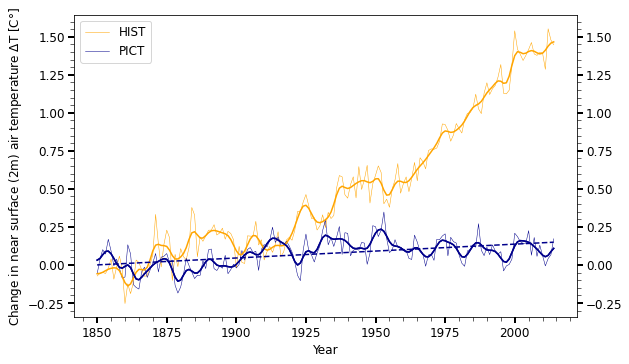

In [15]:
fig, ax = plt.subplots(figsize=figsize)

# plot raw data
plt.plot(years,hist,linewidth=0.5,color='orange')
plt.plot(years,pict,linewidth=0.5,color='darkblue')

# plot running mean
plt.plot(years,smooth(hist,len(hist)),color='orange')
plt.plot(years,smooth(pict,len(pict)),color='darkblue')
plt.plot(years,smooth(pict,len(pict)),color='darkblue')

# plot linear regression
x_vals = np.array((years[0],years[len(years)-1]))
y_vals = res.intercept + res.slope * x_vals
plt.plot(x_vals, y_vals+np.mean(correction), '--',color='darkblue')


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5,labelright=True)
ax.yaxis.set_ticks_position('both')
ax = plt.gca()

plt.ylabel('Change in near surface (2m) air temperature $\Delta$T [C°]')
plt.xlabel('Year')

ax.legend([input_names[0], ctrl_input_names[0]])
plt.savefig('T2M_hist-pict.png', dpi=dpi)



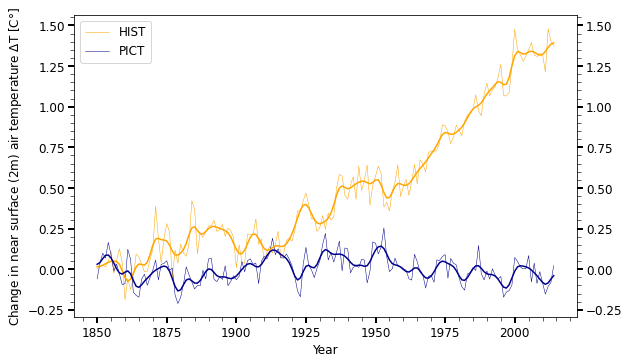

In [18]:
fig, ax = plt.subplots(figsize=figsize)

# plot raw data
plt.plot(years,hist_c,linewidth=0.5,color='orange')
plt.plot(years,pict_c,linewidth=0.5,color='darkblue')

# plot running mean
plt.plot(years,smooth(hist_c,len(hist_c)),color='orange')
plt.plot(years,smooth(pict_c,len(pict_c)),color='darkblue')


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5,labelright=True)
ax.yaxis.set_ticks_position('both')
ax = plt.gca()

plt.ylabel('Change in near surface (2m) air temperature $\Delta$T [C°]')
plt.xlabel('Year')

ax.legend([input_names[0], ctrl_input_names[0]])
plt.savefig('T2M_hist-pict_corrected.png', dpi=dpi)
